## PHASE 2 PROJECT.
### GROUP 2.
#### Members
1. Godfrey Waweru
2. Faith Kamande
3. Joy Kiboi
4. Emmanuel Ndedda





#### Business Problem.
Your company now sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies. You are charged with exploring what types of films are currently doing the best at the box office. You must then translate those findings into actionable insights that the head of your company's new movie studio can use to help decide what type of films to create.


From a pool of Objectives offer three solid recommendations to the firm.

### Objectives.
1. Understand runtime trends considering ratings. ( GODFREY)
2. Potential movie directors that have the highest audience ratings. (JOY)
3. Studios with the highest returns. (JOY)
4. Production budget that yields the most profit return and Evaluate the Impact of Budget on Success. (Godfrey)
5. Understand Genre Performance in terms of ratings (Faith)
6. Identify Profitable Films. (Faith)
7. Find Seasonal or Time-Based Trends (Emmanuel)
8. Compare between the worldwide and domestic patterns which one has more profitable market. (Emmanuel)


### Import necessary Libraries.

In [2]:
#Import necessary libraries.

import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind , mannwhitneyu
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [3]:
# Create a connection to the database `im.db`
conn = sqlite3.connect('Data/im.db')
# Create a  Cursor to execute SQL statements and fetch results from SQL queries
cur = conn.cursor()

In [4]:
# This query returns a tuple containing the table’s names
for row in cur.execute("SELECT name FROM sqlite_master"):
  print(row)

('movie_basics',)
('directors',)
('known_for',)
('movie_akas',)
('movie_ratings',)
('persons',)
('principals',)
('writers',)


### LOAD THE DATA

In [5]:
df_Imdb = pd.read_sql("SELECT * FROM movie_basics",conn)
df_Imdb.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


### Concatinating imporntant data

#### 1.Add ratings to movie_basics

In [6]:
queryRatings = """
SELECT 
    movie_basics.movie_id,
    movie_basics.primary_title,
    movie_basics.original_title,
    movie_basics.start_year,
    movie_basics.runtime_minutes,
    movie_basics.genres,
    movie_ratings.averagerating
FROM movie_basics
JOIN movie_ratings
    ON movie_basics.movie_id = movie_ratings.movie_id
"""
df_Imdb = pd.read_sql(queryRatings, conn)

In [7]:
#### 2.Add column directors from other tables to table movie_basics

In [8]:
queryDirectors = """
SELECT 
    movie_basics.movie_id,
    persons.primary_name AS director_name
FROM movie_basics
LEFT JOIN directors
    ON movie_basics.movie_id = directors.movie_id
LEFT JOIN persons
    ON directors.person_id = persons.person_id
"""
df_dir = pd.read_sql(queryDirectors, conn)

In [9]:
# Merge the data and display the first five rows
df_Imdb = df_Imdb.merge(df_dir, on="movie_id", how="left")
df_Imdb.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,director_name
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,Harnam Singh Rawail
1,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,Harnam Singh Rawail
2,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,Harnam Singh Rawail
3,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,Harnam Singh Rawail
4,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,Mani Kaul


In [10]:
df_Bom = pd.read_csv('Data/bom.movie_gross.csv')
df_Bom.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [11]:
df_Tn = pd.read_csv('Data/tn.movie_budgets.csv')
df_Tn.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [12]:
df_tmdb = pd.read_csv('Data/tmdb.movies.csv')
df_tmdb.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [13]:
df_RtMovieInfo = pd.read_csv("Data/rt.movie_info.tsv", sep="\t")
df_RtMovieInfo.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


In [14]:
df_RtReviews = pd.read_csv("Data/rt.reviews.tsv", sep="\t",encoding='iso-8859-1')
df_RtReviews.head()

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"


## CLEANING THE DATA.


In [15]:
#Cleaning the data.

#Check for missing values in the Bom Data.
print(df_Bom.columns)
print(df_Bom.info())
print(df_Bom.shape)
df_Bom.isna().sum()

#Put the missing values in percentage.
df_Bom.isna().sum()/df_Bom.shape[0]*100

Index(['title', 'studio', 'domestic_gross', 'foreign_gross', 'year'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB
None
(3387, 5)


title              0.000000
studio             0.147623
domestic_gross     0.826690
foreign_gross     39.858282
year               0.000000
dtype: float64

In [16]:
#Replace null in studio with 'Unknown'
df_Bom['studio'] = df_Bom['studio'].fillna('Unknown')

#Drop the null values in the domestic gross column.
df_Bom.dropna(subset=['domestic_gross'], inplace=True)

#Dull the null values in the foreign gross column.
df_Bom.dropna(subset=['foreign_gross'], inplace=True)

#Check for missing values in the Bom Data again.
df_Bom.isna().sum()/df_Bom.shape[0]*100

#Remove , from the foreign_gross column and convert it to float.
df_Bom['foreign_gross'] = df_Bom['foreign_gross'].astype(str).str.replace(',', '').astype(float)

In [17]:
#Check the df_RtMovieInfo Data.

#The columns in the df_RtMovieInfo Data.
print(df_RtMovieInfo.columns)
print(df_RtMovieInfo.info())

#Drop the unnecessary columns.
df_RtMovieInfo.drop(['theater_date','synopsis','dvd_date','currency','box_office','studio'], axis=1, inplace=True)

#The number of rows in the df_RtMovieInfo Data.
print(df_RtMovieInfo.shape)

#Get the null values in the df_RtMovieInfo Data.
df_RtMovieInfo.isna().sum()

#Drop null values.
df_RtMovieInfo.dropna(subset=['rating','genre','director','runtime','writer'], inplace=True)

#Check the null values in the df_RtMovieInfo Data again.
df_RtMovieInfo.isna().sum()


Index(['id', 'synopsis', 'rating', 'genre', 'director', 'writer',
       'theater_date', 'dvd_date', 'currency', 'box_office', 'runtime',
       'studio'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   theater_date  1201 non-null   object
 7   dvd_date      1201 non-null   object
 8   currency      340 non-null    object
 9   box_office    340 non-null    object
 10  runtime       1530 non-null   object
 11  studio        494 non-null    object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB
None
(1560, 6)


id          0
rating      0
genre       0
director    0
writer      0
runtime     0
dtype: int64

In [18]:
#Check the Data df_Tn

#Get the columns and the info in the df_Tn Data.
print(df_Tn.columns)
print(df_Tn.info())

#Get the number of rows in the df_Tn Data.
print(df_Tn.shape)

#Get the null values in the df_Tn Data.
df_Tn.isna().sum()

#The data has no null values.

#Remove the $ and , from the gross and budget columns.
df_Tn['production_budget'] = df_Tn['production_budget'].replace('[\$,]', '', regex=True).astype(float)
df_Tn['worldwide_gross'] = df_Tn['worldwide_gross'].replace('[\$,]', '', regex=True).astype(float)
df_Tn['domestic_gross'] = df_Tn['domestic_gross'].replace('[\$,]', '', regex=True).astype(float)


Index(['id', 'release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB
None
(5782, 6)


In [19]:
#Check the Data df_tmdb.
#The columns and the info in the df_tmdb Data.
print(df_tmdb.columns)
print(df_tmdb.info())

#Get the number of rows in the df_tmdb Data.
print(df_tmdb.shape)

#Get the null values in the df_tmdb Data.
df_tmdb.isna().sum()

#The data has no null values.

Index(['Unnamed: 0', 'genre_ids', 'id', 'original_language', 'original_title',
       'popularity', 'release_date', 'title', 'vote_average', 'vote_count'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB
None
(26517, 10)


Unnamed: 0           0
genre_ids            0
id                   0
original_language    0
original_title       0
popularity           0
release_date         0
title                0
vote_average         0
vote_count           0
dtype: int64

In [20]:
# Cleaning the df_RtReviews data 
df_RtReviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54432 non-null  int64 
 1   review      48869 non-null  object
 2   rating      40915 non-null  object
 3   fresh       54432 non-null  object
 4   critic      51710 non-null  object
 5   top_critic  54432 non-null  int64 
 6   publisher   54123 non-null  object
 7   date        54432 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.3+ MB


In [21]:
df_RtReviews["review"] = df_RtReviews["review"].fillna("Not given")
df_RtReviews["critic"] = df_RtReviews["critic"].fillna("Unknown")
df_RtReviews["publisher"] = df_RtReviews["publisher"].fillna("Unknown")

In [22]:
df_RtReviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54432 non-null  int64 
 1   review      54432 non-null  object
 2   rating      40915 non-null  object
 3   fresh       54432 non-null  object
 4   critic      54432 non-null  object
 5   top_critic  54432 non-null  int64 
 6   publisher   54432 non-null  object
 7   date        54432 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.3+ MB


### ANALYSIS, CONCLUSIONS AND RECOMMENDATIONS

In [23]:
### OBJECTIVE 1. Godfrey.

#Understand runtime trends considering ratings.

# Load necessary tables into pandas DataFrames
movie_basics = pd.read_sql_query("SELECT movie_id, primary_title, genres, runtime_minutes FROM movie_basics", conn)
movie_ratings = pd.read_sql_query("SELECT movie_id, averagerating FROM movie_ratings", conn)

# Merge the tables on 'movie_id'
movies = pd.merge(movie_basics, movie_ratings, on='movie_id')

# Drop rows with missing values
movies = movies.dropna(subset=['genres', 'runtime_minutes', 'averagerating'])

# Split genres and explode the DataFrame
movies['genres'] = movies['genres'].str.split(',')
movies_exploded = movies.explode('genres')

# Calculate the number of movies per genre
genre_distribution = movies_exploded['genres'].value_counts().reset_index()
genre_distribution.columns = ['Genre', 'Movie Count']

print("Genre Distribution:")
print(genre_distribution.head(10))


Genre Distribution:
         Genre  Movie Count
0        Drama        28394
1  Documentary        16423
2       Comedy        15514
3     Thriller         7583
4       Horror         6917
5       Action         6297
6      Romance         5976
7        Crime         4338
8    Biography         3693
9    Adventure         3621


In [24]:
# Group by runtime and calculate average rating
runtime_performance = movies.groupby('runtime_minutes')['averagerating'].mean().reset_index()

# Sort by average rating
runtime_performance = runtime_performance.sort_values(by='averagerating', ascending=False)

print("Average Rating by Runtime:")
print(runtime_performance.head(10))


Average Rating by Runtime:
     runtime_minutes  averagerating
280            607.0           9.30
269            379.0           9.20
270            383.0           9.20
239            261.0           9.00
286           1440.0           8.90
273            467.0           8.90
231            247.0           8.85
203            207.0           8.80
249            287.0           8.70
268            364.0           8.70


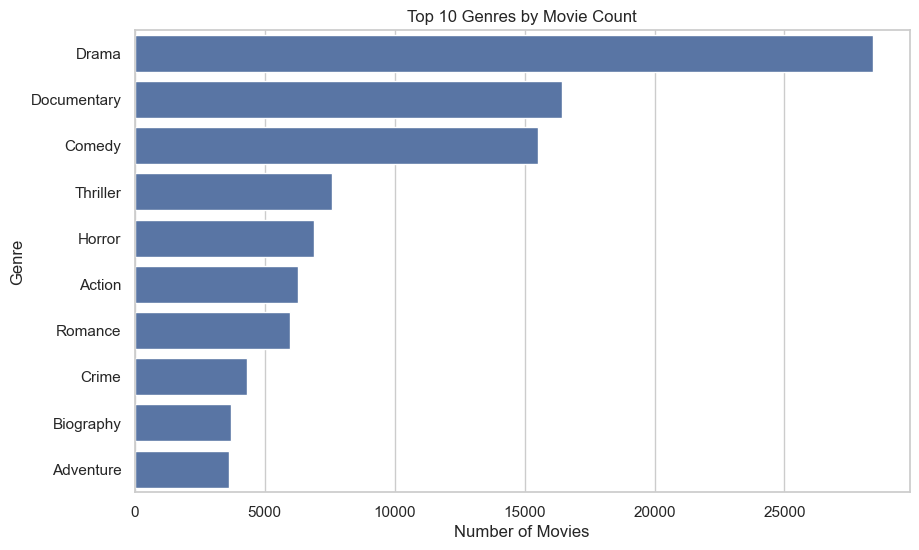

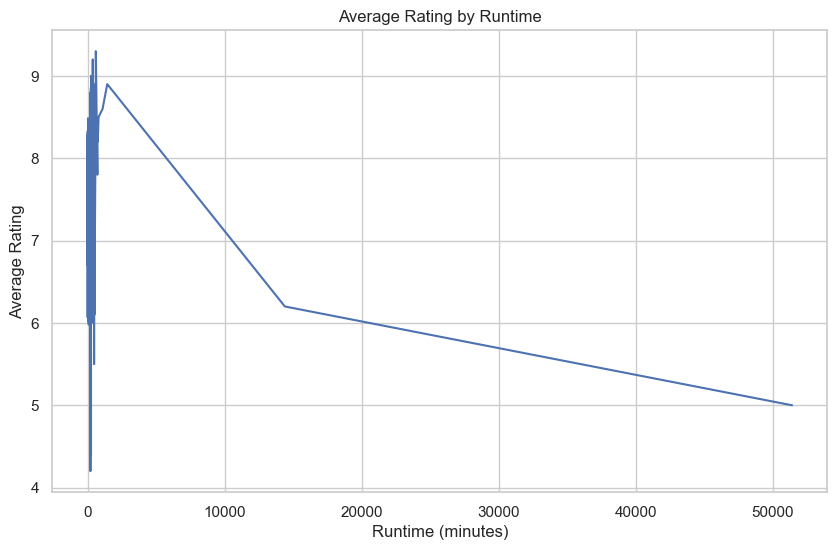

In [25]:
# Plotting the results.
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
sns.set(style="whitegrid")

# Plot genre distribution
plt.figure(figsize=(10, 6))
sns.barplot(x='Movie Count', y='Genre', data=genre_distribution.head(10))
plt.title('Top 10 Genres by Movie Count')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.show()

# Plot average rating by runtime
plt.figure(figsize=(10, 6))
sns.lineplot(x='runtime_minutes', y='averagerating', data=runtime_performance)
plt.title('Average Rating by Runtime')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Average Rating')
plt.show()

### Statistical Data intergration

In [26]:
# Converts the movie runtime into a numeric format.
df_Imdb['runtime_minutes'] = pd.to_numeric(df_Imdb['runtime_minutes'], errors='coerce')

# Splits the movies into two groups: shorter <120 and longer >=120
shortMovies = df_Imdb[df_Imdb['runtime_minutes'] < 120]['averagerating']
longMovies = df_Imdb[df_Imdb['runtime_minutes'] >= 120]['averagerating']

# Compares the average ratings of these two groups using a t-test.
tValue, pValue = ttest_ind(shortMovies, longMovies)

#Prints the test results
print(f"T_Value: {tValue}, P_Value: {pValue}")

# Interpret the result
if pValue < 0.05:
    print("There is a difference between long and short movie ratings")
else:
    print("There is less difference between long and short movie ratings")

T_Value: -13.983737407873448, P_Value: 2.0779210380104707e-44
There is a difference between long and short movie ratings


Since the p-value is less than 0.05, the result is statistically significant, meaning:

The difference in ratings between short and long movies is not due to random chance.

The output of this having shorter movies <120 and longer movies >120 indicates that there is a great difference on average rating and it also not random indicating that runtime influences the audience ratings

### CONCLUSION.
The attributes used to evaluate movie perfomance and ratings include the run time in minutes and the movie popularity using movie count.

It is advisable for the movie studio to highly consider venturing into movies with shorter run time as the longer the periods the lower the ratings as shown above.

It is also advisable for the movie studio to venture into genres such as Dramas and Documentaries as from the analysis above, these genres earned the spot as the most popular genres over others such as Adventures, Biographies and Crime movies.

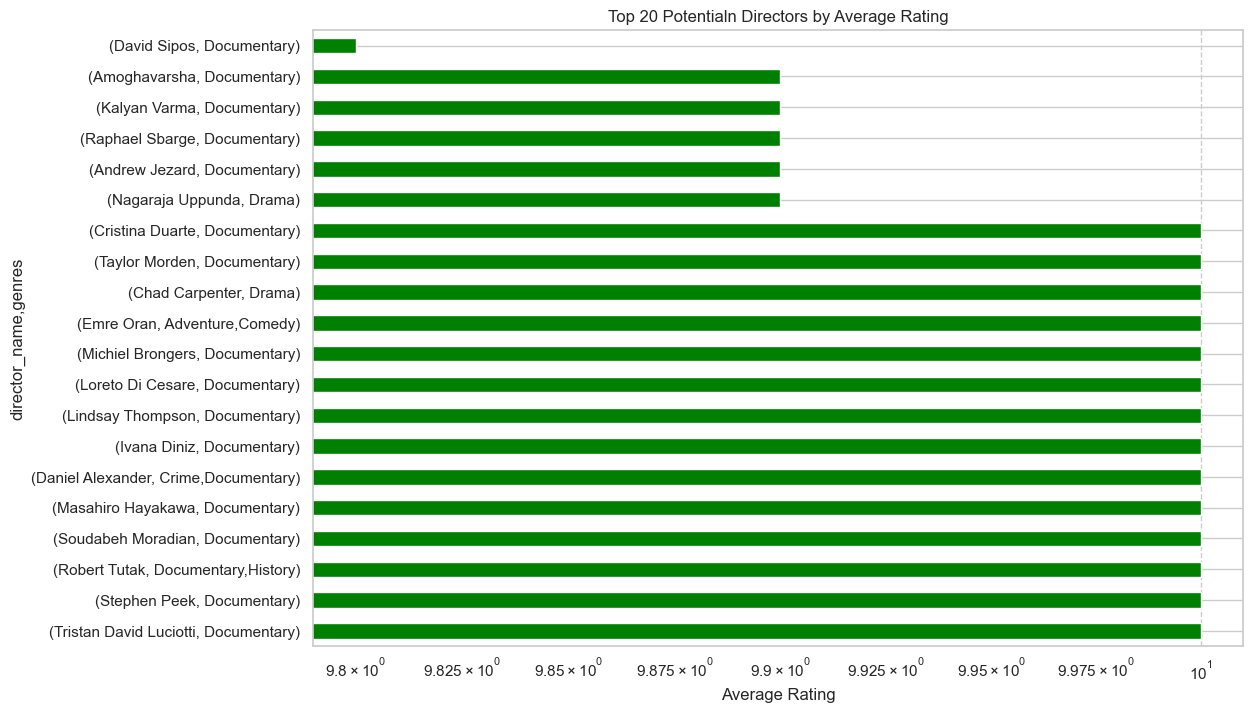

In [27]:
# Objective 2. Potential movie directors that have the highest audience ratings. Joy.
dAvgRating = df_Imdb.groupby(['director_name','genres'])['averagerating'].mean().sort_values(ascending=False).head(20)

plt.figure(figsize=(12,8))
dAvgRating.plot(kind='barh', color='green')
plt.title('Top 20 Potentialn Directors by Average Rating')
plt.xlabel('Average Rating')
plt.xscale('log')
plt.grid(axis='x', linestyle='--')
plt.show()

### CONCLUSION

From the analysis we can conclude that Robert Tutak,Taylor Morden and MIchiel Brongers are the top rated Directors in the film indurstry.

We can therefore reccomend patnering with them in various projects.

Also considering the analysis focus on documentaries as the most top rated directors specialize in this genre

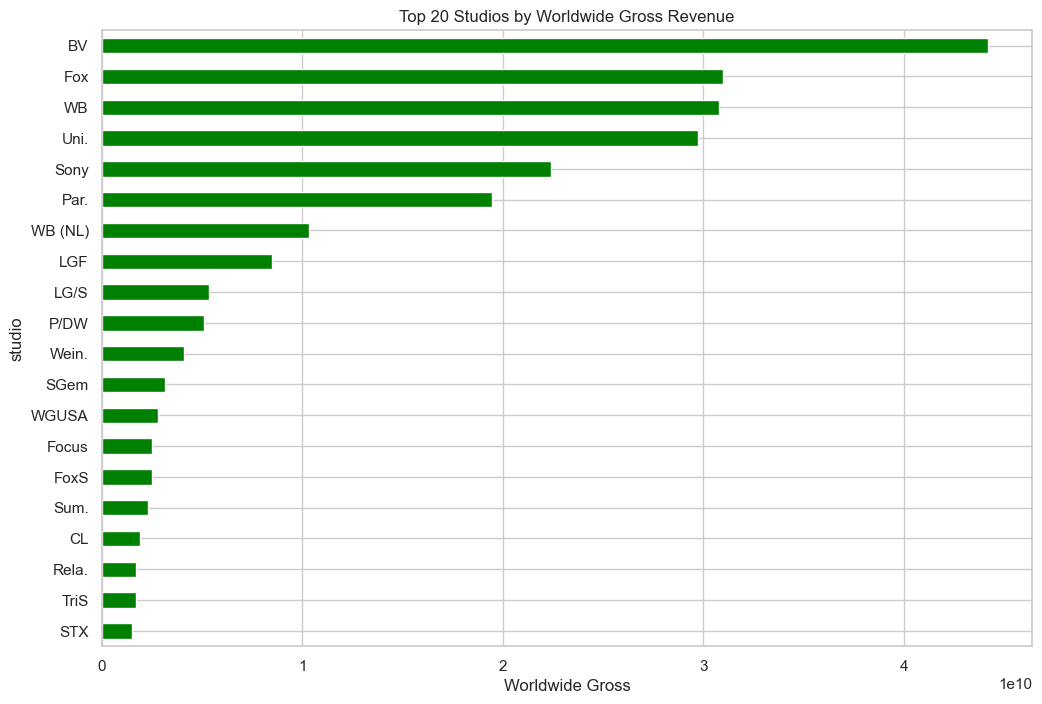

In [28]:
# Objective 3. Studios with the highest returns. Joy.
 
# Create a worldwide gross then lets see the best studio with the highest revenue
df_Bom['worldwide_gross'] = df_Bom['domestic_gross'] + df_Bom['foreign_gross']
# Group by Studio
studio_gross = df_Bom.groupby('studio')['worldwide_gross'].sum().sort_values(ascending=False).head(20)

plt.figure(figsize=(12,8))
studio_gross.plot(kind='barh', color='green')
plt.title('Top 20 Studios by Worldwide Gross Revenue')
plt.xlabel('Worldwide Gross')
plt.gca().invert_yaxis()
plt.show()

From the analysis above it indicates that `BV` studio generates the highest revenue worldwide followed by `Fox` and `WB`.

We can therefore recommend considerations ,patnerships and building business models considering these studios.


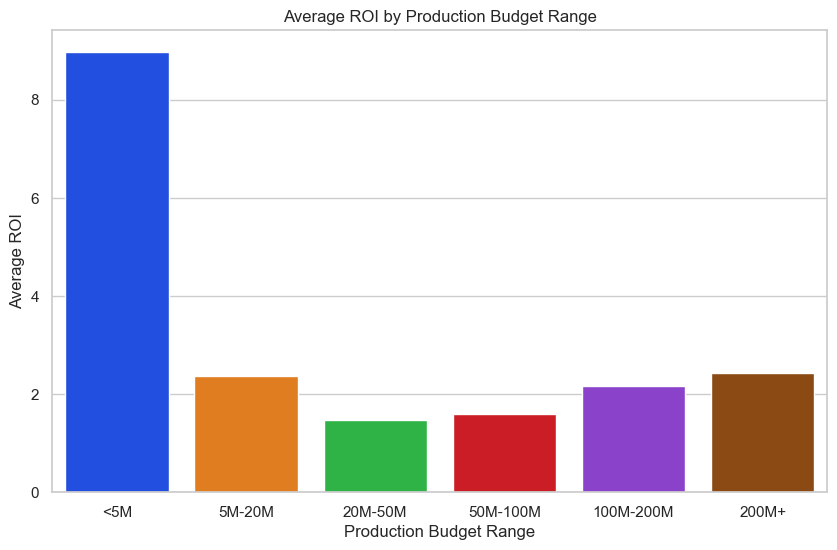

In [48]:
# 0BJECTIVE 4. Godfrey.
#Production budget that yields the most profit return and Evaluate the Impact of Budget on Success.

# Calculate ROI to guide budget allocation
df_Tn['ROI'] = (df_Tn['worldwide_gross'] - df_Tn['production_budget']) / df_Tn['production_budget']

# Create Budget Bins
budgetBins = [0, 5000000, 20000000, 50000000, 100000000, 200000000, 500000000]
budgetLabels = ['<5M', '5M-20M', '20M-50M', '50M-100M', '100M-200M', '200M+']
df_Tn['budget_bin'] = pd.cut(df_Tn['production_budget'], bins=budgetBins, labels=budgetLabels)

# Group and Plot
budgetRoi = df_Tn.groupby('budget_bin', observed=True)['ROI'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x='budget_bin', y='ROI',hue = 'budget_bin', data=budgetRoi, palette="bright")
plt.title('Average ROI by Production Budget Range')
plt.xlabel('Production Budget Range')
plt.ylabel('Average ROI')
plt.show()

 


### CONCLUSION

The analysis above used the budget and worldwide gross to find the returns on the movies produced by various studios. 
From the analysis, we came to a conclusion that the movies with the lowest budgets recorded higher returns.
This therefore means that for the studio to gain high returns it is not necessary for them to spend a lot in production as less budgets produce higher returns

<Figure size 1200x1400 with 0 Axes>

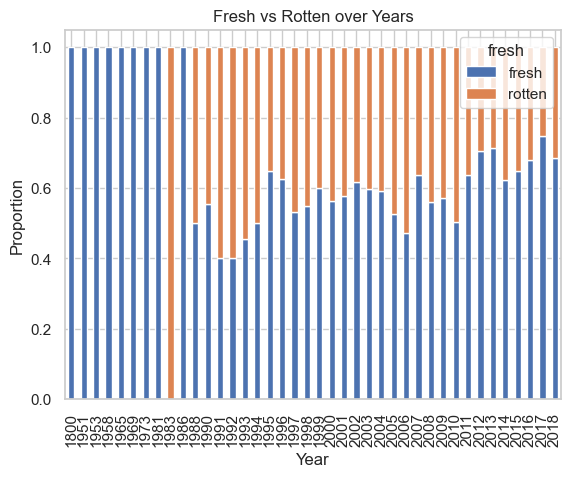

In [30]:
# OBJECTIVE 5. Faith.
## Understand Genre Performance in terms of ratings
df_RtReviews['date'] = pd.to_datetime(df_RtReviews['date'], errors='coerce')

plt.figure(figsize=(12,14))
df_RtReviews.groupby(df_RtReviews['date'].dt.year)['fresh'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True)
plt.title('Fresh vs Rotten over Years')
plt.ylabel('Proportion')
plt.xlabel('Year')
plt.show()

Top Genres by Average Rating:
         genres  averagerating
21        Short       8.800000
7   Documentary       7.332090
11    Game-Show       7.300000
17         News       7.271330
4     Biography       7.162274
14        Music       7.091972
12      History       7.040956
22        Sport       6.961493
24          War       6.584291
18   Reality-TV       6.500000


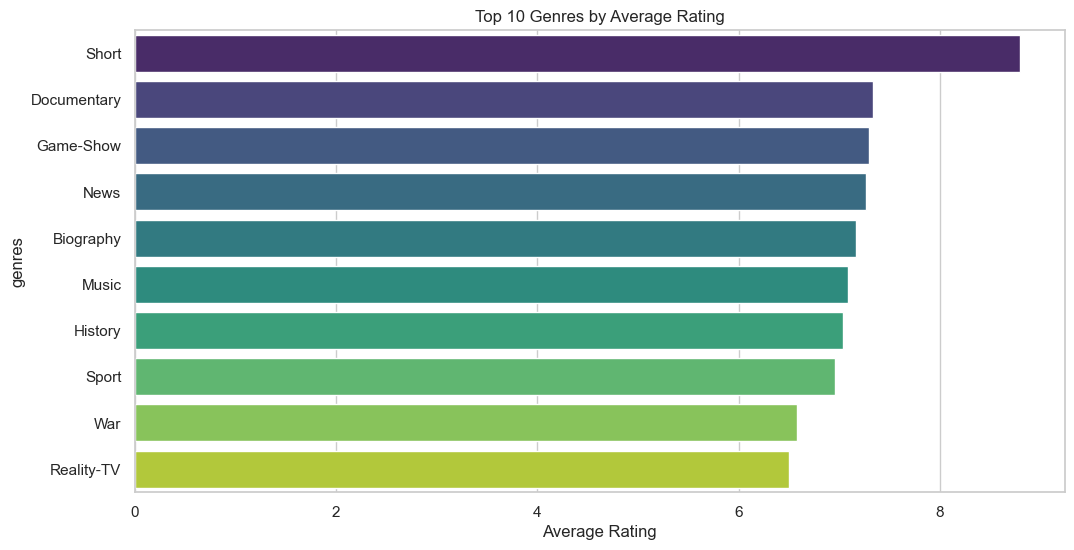

In [31]:
# Load necessary tables into pandas DataFrames
movie_basics_genre = pd.read_sql_query("SELECT movie_id, primary_title, genres FROM movie_basics", conn)
movie_ratings_genre = pd.read_sql_query("SELECT movie_id, averagerating FROM movie_ratings", conn)
# Merge movie_basics and movie_ratings on 'movie_id'
movies = pd.merge(movie_basics_genre, movie_ratings_genre, on='movie_id')

# Split genres and explode the DataFrame
movies['genres'] = movies['genres'].str.split(',')
movies_exploded = movies.explode('genres')

# Calculate average rating per genre
genre_ratings = movies_exploded.groupby('genres')['averagerating'].mean().reset_index()
genre_ratings =genre_ratings.sort_values(by='averagerating', ascending=False)

print("Top Genres by Average Rating:")
print(genre_ratings.head(10))

plt.figure(figsize=(12, 6))
sns.barplot(x='averagerating', y='genres',hue = 'genres',data=genre_ratings.head(10), palette='viridis')
plt.title('Top 10 Genres by Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('genres')
plt.show()


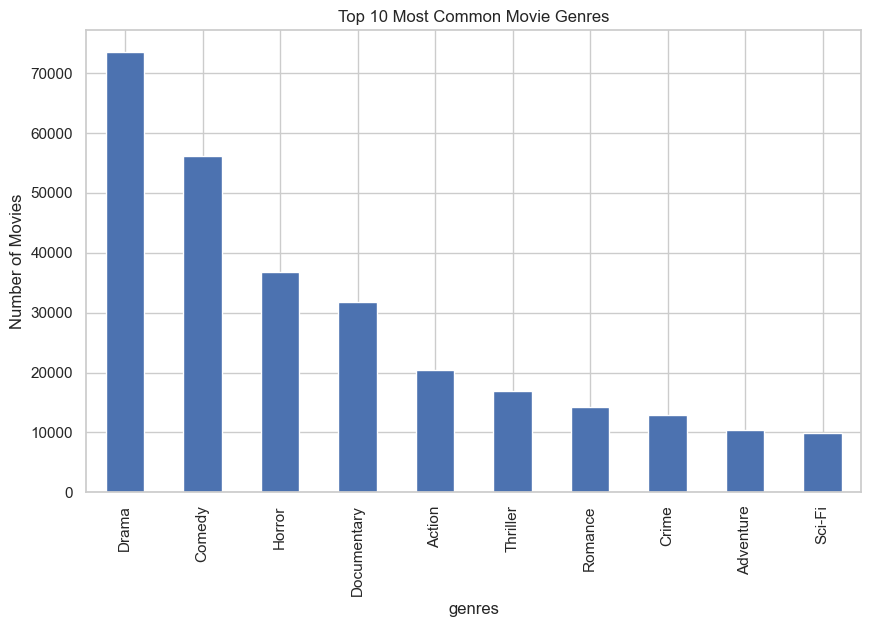

In [32]:
df_Imdb['genres'] = df_Imdb['genres'].str.split(',')
movie_basics_exploded = df_Imdb.explode('genres')
movie_basics_exploded['genres'] = movie_basics_exploded['genres'].str.strip()

# Merging movie_basics with movie_ratings 
merged_data = pd.merge(movie_basics_exploded, movie_ratings, on='movie_id', how='left')

# Count the number of occurrences of each genre
genre_counts = merged_data['genres'].value_counts()

# Plot the top 10 most common genres
genre_counts.head(10).plot(kind='bar', figsize=(10,6), title='Top 10 Most Common Movie Genres')
plt.ylabel('Number of Movies')
plt.show()

### CONCLUSION

- 1980–2000: There's a sharp increase in Rotten reviews. Audiences/critics were much more critical or standards.
- Post-2000: Gradual recovery towards more Fresh reviews, indicating improved audience sentiment or changes in production quality, distribution, or critical approach.
- Modern movies (post-2000) are increasingly winning back positive reception.
- From the above observations we therefore recommend that inorder to get fresh reviews from critis and our target audience ,the movies/films produced should be of higher quality,mordern and good standards.



- Documentary and Drama dominate in number of movies produced over 50,000, meaning they are the most engaged genres by creators.
- genres like Short and Game Show, which are highly rated, do not even appear in the top 10 most common meaning they might have higher audience satisfaction but lower production volume which means its an open market.
- Drama and Comedy are highly produced but not the highest rated.
From the observation made the films/movies should Focus on quality, niche genres for loyal audiences and popular genres for broader reach.

In [33]:
#OBJECTIVE 6. Faith.
## Identify Profitable Films
#Check top ten movies with the highest domestic gross.
top_domestic_gross = df_Bom [['title','domestic_gross']].sort_values(by='domestic_gross', ascending=False).head(10)
print(top_domestic_gross)

#Check top ten movies with the highest foreign gross.
top_foreign_gross = df_Bom [['title','foreign_gross']].sort_values(by='foreign_gross', ascending=False).head(10)
print(top_foreign_gross)

                             title  domestic_gross
1872  Star Wars: The Force Awakens     936700000.0
3080                 Black Panther     700100000.0
3079        Avengers: Infinity War     678800000.0
1873                Jurassic World     652300000.0
727          Marvel's The Avengers     623400000.0
2758      Star Wars: The Last Jedi     620200000.0
3082                 Incredibles 2     608600000.0
2323  Rogue One: A Star Wars Story     532200000.0
2759   Beauty and the Beast (2017)     504000000.0
2324                  Finding Dory     486300000.0
                                            title  foreign_gross
328   Harry Potter and the Deathly Hallows Part 2    960500000.0
1875                      Avengers: Age of Ultron    946400000.0
727                         Marvel's The Avengers    895500000.0
3081               Jurassic World: Fallen Kingdom    891800000.0
1127                                       Frozen    875700000.0
2764                               Wolf Warrior 2

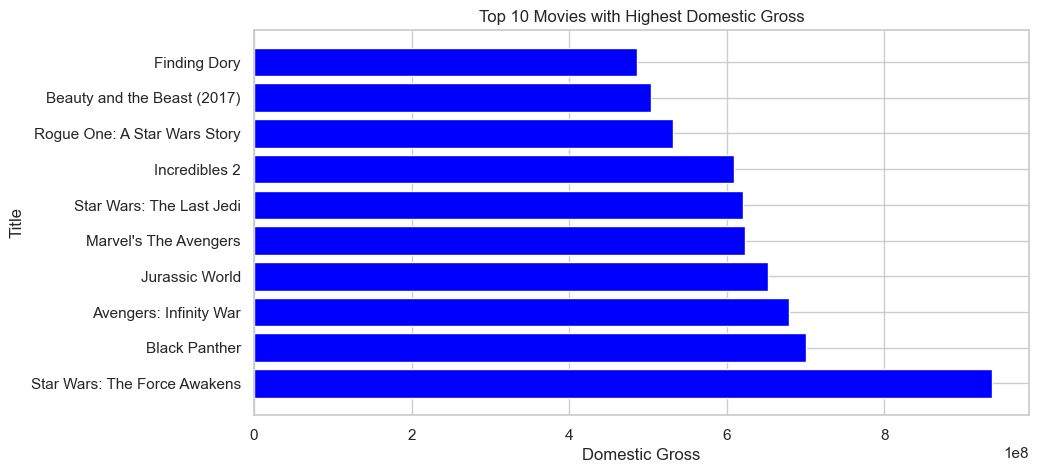

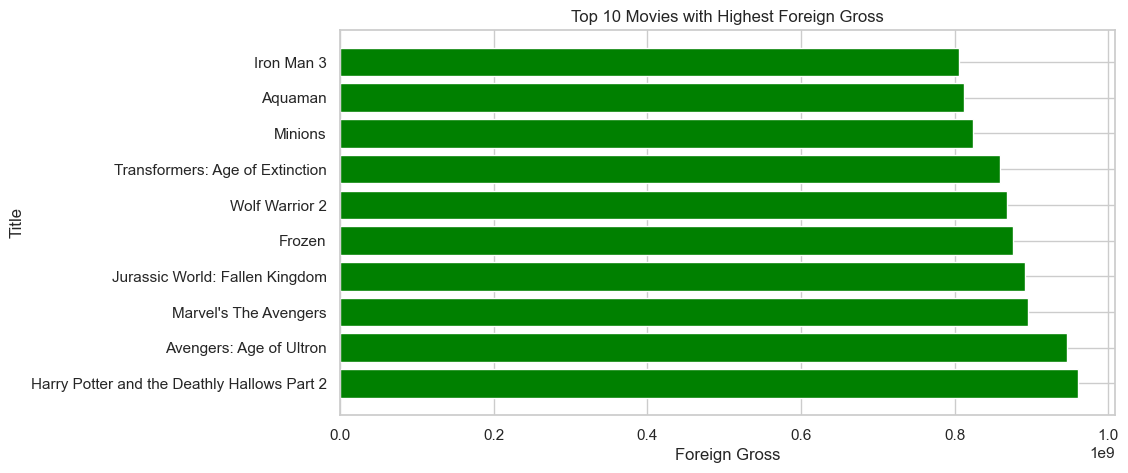

In [34]:
#Plot the top ten movies with the highest domestic gross.
plt.figure(figsize=(10,5))
plt.barh(top_domestic_gross['title'], top_domestic_gross['domestic_gross'], color='blue')
plt.xlabel('Domestic Gross')
plt.ylabel('Title')
plt.title('Top 10 Movies with Highest Domestic Gross')
plt.show()
#Plot the top ten movies with the highest foreign gross.
plt.figure(figsize=(10,5))
plt.barh(top_foreign_gross['title'], top_foreign_gross['foreign_gross'], color='green')
plt.xlabel('Foreign Gross')
plt.ylabel('Title')
plt.title('Top 10 Movies with Highest Foreign Gross')
plt.show()

#### CONCLUSION

- Marvel's The Avengers appears in both the domestic and foreign top 10 meaning it has a huge worldwide appeal thus very profitable.
- Profitable films are often franchise-based, family-friendly, superhero-related, and supported by strong international appeal.We can therefore recommend considering the franchise-based, family-friendly and superhero-related movies/Films.

OBJECTIVE 7 : Find Seasonal or Time-Based Trends

In [35]:
#OBJECTIVE 7 : Find Seasonal or Time-Based Trends. Emmanuel.
# Convert 'release_date' column to datetime
df_Tn['release_date'] = pd.to_datetime(df_Tn['release_date'])

# Extract month name from release_date
df_Tn['month'] = df_Tn['release_date'].dt.month_name()

df_Tn.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,ROI,budget_bin,month
0,1,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09,5.532577,200M+,December
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,1.546673,200M+,May
2,3,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,-0.572108,200M+,June
3,4,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,3.243841,200M+,May
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,3.153696,200M+,December


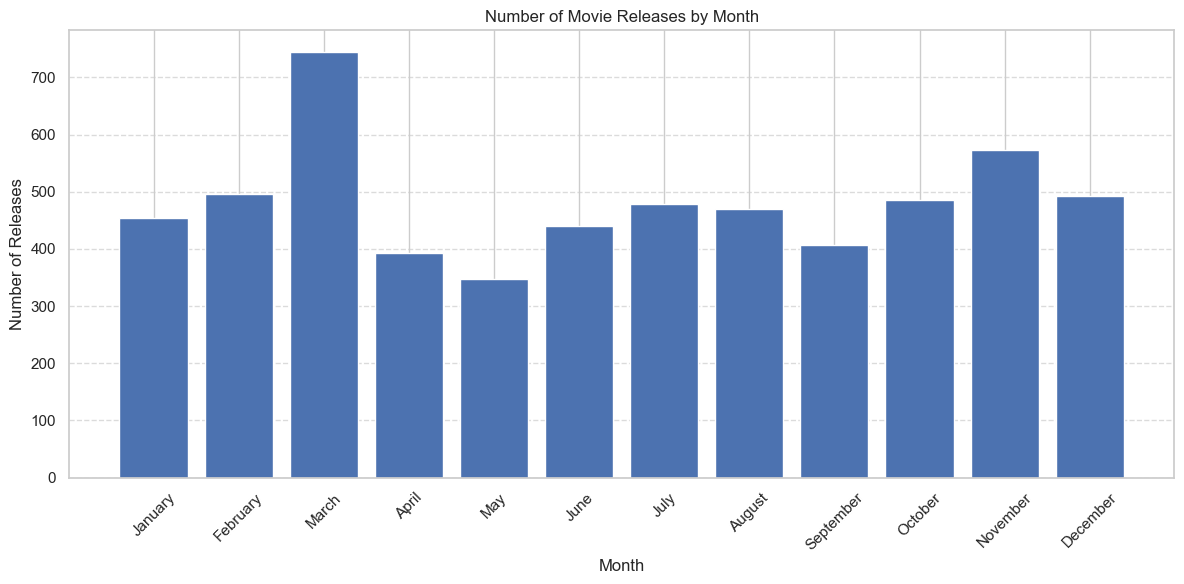

In [36]:
# Count movie releases per month
monthly_release_counts = df_Tn["month"].value_counts().sort_index()

# Month labels for plotting
months = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]

# Plotting the bar chart
plt.figure(figsize=(12, 6))
plt.bar(months, monthly_release_counts)
plt.title("Number of Movie Releases by Month")
plt.xlabel("Month")
plt.ylabel("Number of Releases")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

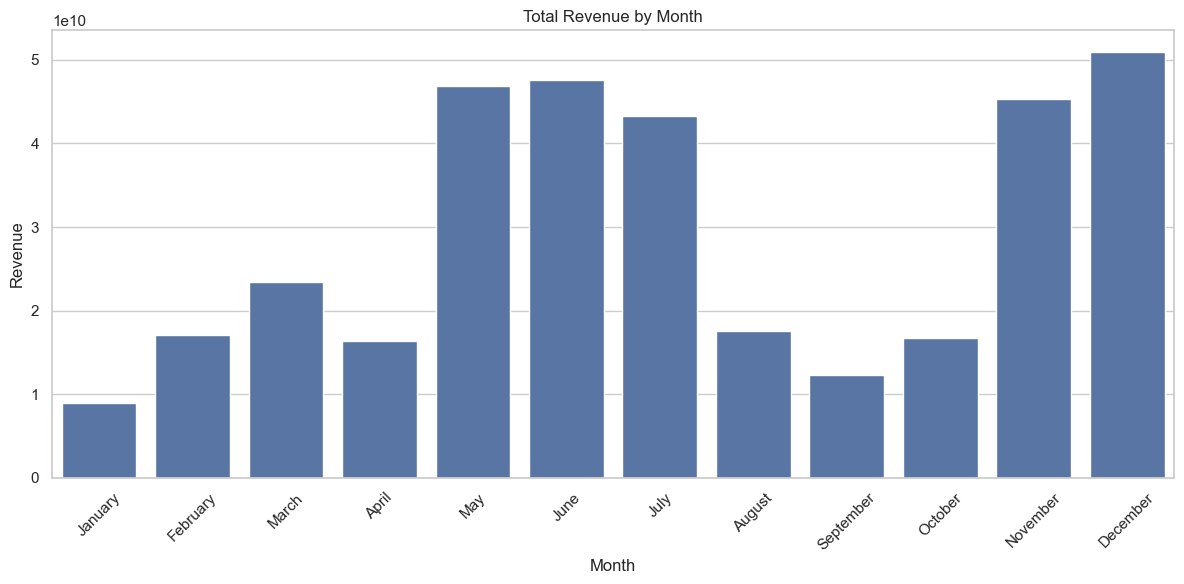

In [37]:
# Create colunm for profit
df_Tn['Profits'] = df_Tn['worldwide_gross']-df_Tn['production_budget']

# checking for the revenue distribution per month
revenue_by_month = df_Tn.groupby('month')['Profits'].sum().reset_index()
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

# Create the plot
plt.figure(figsize=(12,6))
sns.barplot(x='month', y='Profits', data=revenue_by_month, order=month_order)

plt.title('Total Revenue by Month')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

CONCLUSION.

- May, June and July have fewer movies being released but have relatively higher revenue income and would therefore recommend the company to consider creating a film during these months due to low traffic from newer movies but still maximixe on the profits
- Movies released in November and December have higher revenue generation compared to other months. i would therefore recommend the company to consider releasing their movies during these months.

OBJECTIVE 8 : Compare between the worldwide and domestic patterns which one has more profitable market.

In [38]:
# OBJECTIVE 8. Emmanuel.
# Domestic and Worldwide Profits
df_Tn['domestic_profit'] = df_Tn['domestic_gross'] - df_Tn['production_budget']
df_Tn['worldwide_profit'] = df_Tn['worldwide_gross'] - df_Tn['production_budget']

# International Gross (Worldwide minus Domestic)
df_Tn['international_gross'] = df_Tn['worldwide_gross'] - df_Tn['domestic_gross']

# International Profit (International Gross - Production Budget)
df_Tn['international_profit'] = df_Tn['international_gross'] - df_Tn['production_budget']
df_Tn.head()


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,ROI,budget_bin,month,Profits,domestic_profit,worldwide_profit,international_gross,international_profit
0,1,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09,5.532577,200M+,December,2.351345e+09,335507625.0,2.351345e+09,2.015838e+09,1.590838e+09
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,1.546673,200M+,May,6.350639e+08,-169536125.0,6.350639e+08,8.046000e+08,3.940000e+08
2,3,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,-0.572108,200M+,June,-2.002376e+08,-307237650.0,-2.002376e+08,1.070000e+08,-2.430000e+08
3,4,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,3.243841,200M+,May,1.072414e+09,128405868.0,1.072414e+09,9.440081e+08,6.134081e+08
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,3.153696,200M+,December,9.997217e+08,303181382.0,9.997217e+08,6.965404e+08,3.795404e+08


In [39]:
# Create a column named gross that shows movies based on whether they were focused on deomestic or worldwide market
df_Tn['gross'] = df_Tn['domestic_gross'] < df_Tn['worldwide_gross']

df_Tn.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,ROI,budget_bin,month,Profits,domestic_profit,worldwide_profit,international_gross,international_profit,gross
0,1,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09,5.532577,200M+,December,2.351345e+09,335507625.0,2.351345e+09,2.015838e+09,1.590838e+09,True
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,1.546673,200M+,May,6.350639e+08,-169536125.0,6.350639e+08,8.046000e+08,3.940000e+08,True
2,3,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,-0.572108,200M+,June,-2.002376e+08,-307237650.0,-2.002376e+08,1.070000e+08,-2.430000e+08,True
3,4,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,3.243841,200M+,May,1.072414e+09,128405868.0,1.072414e+09,9.440081e+08,6.134081e+08,True
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,3.153696,200M+,December,9.997217e+08,303181382.0,9.997217e+08,6.965404e+08,3.795404e+08,True


In [40]:
# Creating a sample for data that had focused on domestic market
sample_true = df_Tn[df_Tn['gross'] == True].sample(n=10, random_state=42)
print(sample_true)

      id release_date               movie  production_budget  domestic_gross  \
3794  95   2000-09-08  The Way of the Gun          9000000.0       6047856.0   
4461  62   2016-12-31      Airlift (2016)          4400000.0             0.0   
188   89   2012-05-11        Dark Shadows        150000000.0      79727149.0   
326   27   2004-12-17         The Aviator        110000000.0     102608827.0   
3235  36   2012-10-12   Seven Psychopaths         13500000.0      15024049.0   
3135  36   2008-03-14         Funny Games         15000000.0       1294640.0   
1371  72   2001-05-11   A Knightâs Tale         41000000.0      56083966.0   
1425  26   2004-10-15     Shall We Dance?         40000000.0      57887882.0   
206    7   2009-05-08           Star Trek        140000000.0     257730019.0   
2447  48   2007-04-06           Zwartboek         22000000.0       4398532.0   

      worldwide_gross       ROI budget_bin      month      Profits  \
3794       13061935.0  0.451326     5M-20M  Septe

In [41]:
# Creating a sample ofmovies that focused on the worldwide market
sample_false= df_Tn[df_Tn['gross'] == False].sample(n=10, random_state=42)
print(sample_false)

      id release_date                   movie  production_budget  \
1729  30   1998-09-04               Knock Off         35000000.0   
3268  69   1996-07-10         Harriet the Spy         13000000.0   
5724  25   2015-09-01          Run, Hide, Die            50000.0   
3586  87   1994-11-23  A Low Down Dirty Shame         10000000.0   
5350  51   2015-08-28           Windsor Drive           850000.0   
5021  22   1968-08-03           Hang 'em High          1800000.0   
5745  46   1972-06-30             Deep Throat            25000.0   
4308   9   1996-06-21               Lone Star          5000000.0   
4560  61   2008-08-26          Purple Violets          4000000.0   
2444  45   2001-09-21   Megiddo: Omega Code 2         22000000.0   

      domestic_gross  worldwide_gross          ROI budget_bin      month  \
1729      10319915.0       10319915.0    -0.705145    20M-50M  September   
3268      26570048.0       26570048.0     1.043850     5M-20M       July   
5724             0.0   

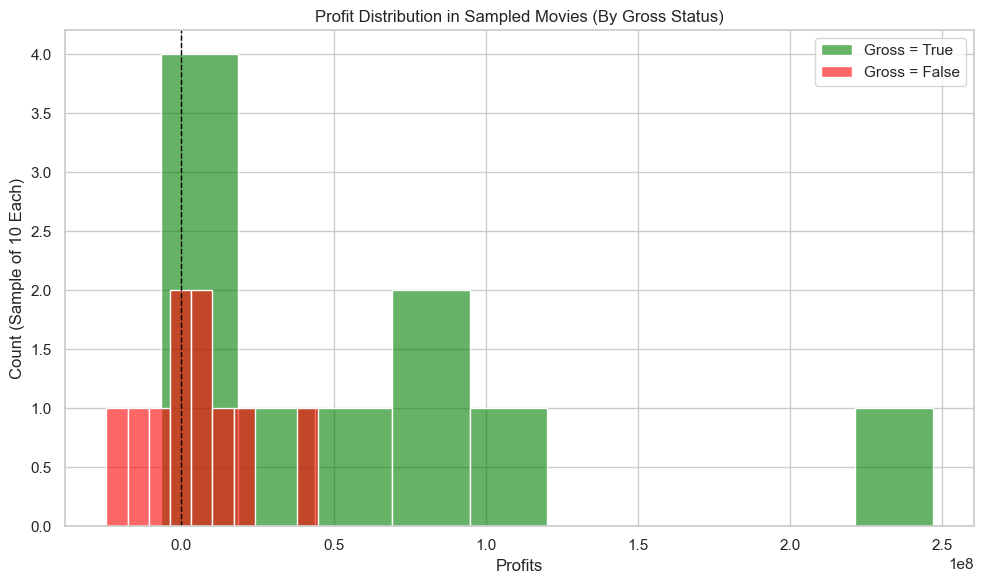

In [42]:
# Sample 10 movies where gross is True
sample_true = df_Tn[df_Tn['gross'] == True].sample(n=10, random_state=42)

# Sample 10 movies where gross is False
sample_false = df_Tn[df_Tn['gross'] == False].sample(n=10, random_state=42)

# Combine both samples
sample_df = pd.concat([sample_true, sample_false]).reset_index(drop=True)

# Plot histogram comparing Profits
plt.figure(figsize=(10, 6))

sns.histplot(sample_df[sample_df['gross'] == True]['Profits'],
             color='green', label='Gross = True', kde=False, stat='count', bins=10, alpha=0.6)

sns.histplot(sample_df[sample_df['gross'] == False]['Profits'],
             color='red', label='Gross = False', kde=False, stat='count', bins=10, alpha=0.6)

plt.axvline(0, color='black', linestyle='--', linewidth=1)  # Zero-profit reference line
plt.title('Profit Distribution in Sampled Movies (By Gross Status)')
plt.xlabel('Profits')
plt.ylabel('Count (Sample of 10 Each)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()      

### Statistical Data Intergration

In [43]:
# State null and alternate hypothesis
# Null - There is no significant difference in foreign and domestic revenue
# Alternate - There is significant difference in foreign and domestic revenue

# Extract profits for each group from the gross column
profits_true = df_Tn[df_Tn['gross'] == True]['Profits']
profits_false = df_Tn[df_Tn['gross'] == False]['Profits']

# Profits are skewed and contain outliers therefore we use `mannwhitneyu` 
# It's used to determine if two independent groups come from the same distribution without assuming normality. 
stat, p = mannwhitneyu(profits_true, profits_false, alternative='two-sided')

# Print the Output
print("Mann-Whitney U Test Ouput Result:")
print(f"U Statistic: {stat:.3f}")
print(f"p-value: {p:.4f}")

# Interpretation
alpha = 0.05
if p < alpha:
    print("\n Reject the null hypothesis.")
    print("There is a significant difference in Profits between gross == True and gross == False groups.")
else:
    print("\n Fail to reject the null hypothesis.")
    print("There is no significant difference in Profits between the two groups.")

Mann-Whitney U Test Ouput Result:
U Statistic: 5103875.000
p-value: 0.0000

 Reject the null hypothesis.
There is a significant difference in Profits between gross == True and gross == False groups.


CONCLUSION
- From the analysis above, movies that focused on the foreign market recorded higher profits than those that focused on the domestic market. We can therefore recommend the studio to focus more on the foreign markets.


### MODELING.


#### Model For predicting 

Intercept: -7285667.0545916855
Coefficient: 2.126943380603295


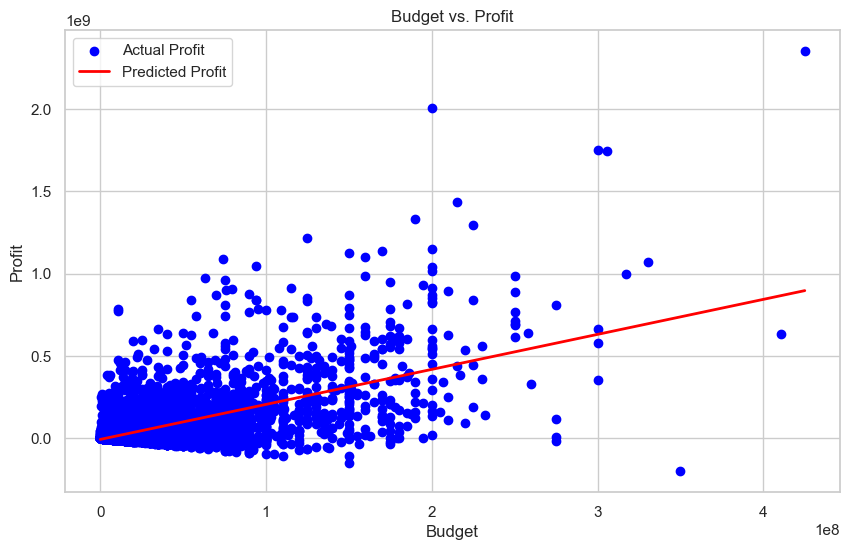

In [44]:
#Model 1; Evaluate the Impact of Budget on Success.

# Reshape data for modeling
X = df_Tn[['production_budget']]
y = df_Tn['Profits']

# Initialize and fit the model
model = LinearRegression()
model.fit(X, y)

# Display coefficients
print(f"Intercept: {model.intercept_}")
print(f"Coefficient: {model.coef_[0]}")

# Predict profits
df_Tn['predicted_profit'] = model.predict(X)

# Plot actual vs. predicted profits
plt.figure(figsize=(10,6))
plt.scatter(df_Tn['production_budget'], df_Tn['Profits'], color='blue', label='Actual Profit')
plt.plot(df_Tn['production_budget'], df_Tn['predicted_profit'], color='red', linewidth=2, label='Predicted Profit')
plt.xlabel('Budget')
plt.ylabel('Profit')
plt.title('Budget vs. Profit')
plt.legend()
plt.show()


In [45]:
#Test the model.
# Load and prepare data for the budget vs. profit model

X_budget = df_Tn[['production_budget']]
y_budget = df_Tn['Profits']

# Train the budget vs. profit model
model_budget = LinearRegression()
model_budget.fit(X_budget, y_budget)
predictions_budget = model_budget.predict(X_budget)

# Evaluate the budget vs. profit model
r2_budget = r2_score(y_budget, predictions_budget)
mae_budget = mean_absolute_error(y_budget, predictions_budget)
mse_budget = mean_squared_error(y_budget, predictions_budget)
rmse_budget = np.sqrt(mse_budget)

print("Budget vs. Profit Model Evaluation:")
print(f"R-squared: {r2_budget:.4f}")
print(f"Mean Absolute Error: {mae_budget:.4f}")
print(f"Mean Squared Error: {mse_budget:.4f}")
print(f"Root Mean Squared Error: {rmse_budget:.4f}")

Budget vs. Profit Model Evaluation:
R-squared: 0.3706
Mean Absolute Error: 60613059.8701
Mean Squared Error: 13430751516830040.0000
Root Mean Squared Error: 115891119.2319


An R² value of 0.3706 indicates that approximately 37.06% of the variability in movie profits can be explained by the production budget using this linear regression model. This suggests a moderate linear relationship between budget and profit. While there is some predictive power, a significant portion (about 62.94%) of the variability in profits remains unexplained by the model, possibly due to other influencing factors not included in the analysis.
The MAE represents the average absolute difference between the predicted profits and the actual profits. An MAE of approximately $60.6 million indicates that, on average, the model's profit predictions deviate from the actual profits by this amount. Given the scale of movie budgets and profits, this error margin is substantial and suggests that the model's predictions may not be sufficiently precise for practical applications.
The MSE measures the average squared difference between the predicted and actual profits. A high MSE value, such as this, indicates large errors in the model's predictions. The squaring of errors means that larger errors have a disproportionately significant impact on the MSE, highlighting the presence of substantial prediction inaccuracies.


Model 2;Understand Runtime Trends Considering Ratings.

Intercept: 6.326533495456424
Coefficient: -4.86916598761367e-05


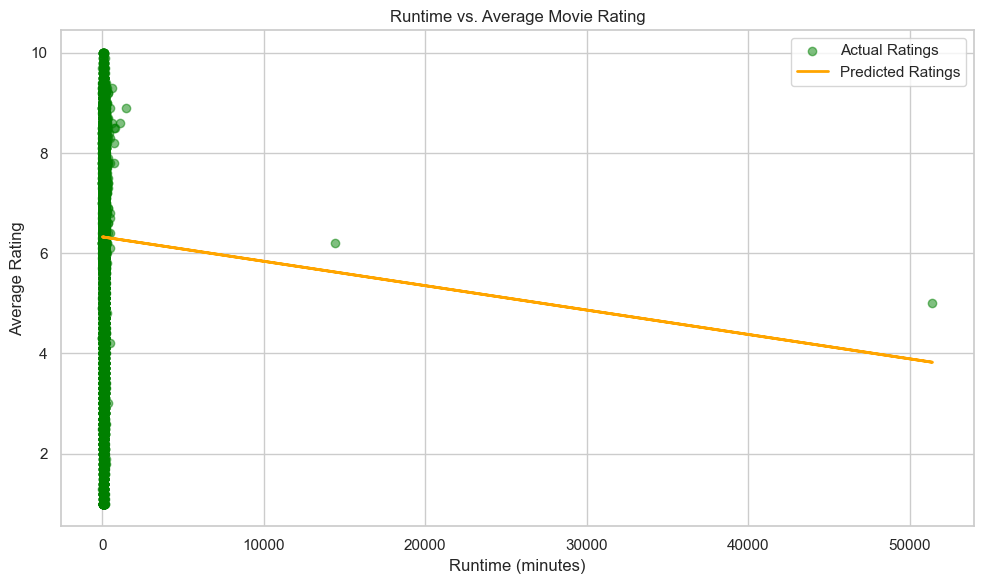

In [46]:
#Model 2; Understand Runtime Trends Considering Ratings.

# Merge the two DataFrames on 'movie_id'
merged_df = pd.merge(movie_basics, movie_ratings, on='movie_id')

# Export the merged DataFrame to a CSV file
merged_df.to_csv('runtime_vs_rating.csv', index=False)

# Close the database connection
conn.close()

# Read the data from the CSV file
df = pd.read_csv('runtime_vs_rating.csv')

# Rename columns for consistency
df.rename(columns={
    'runtime_minutes': 'runtime',
    'averagerating': 'rating'
}, inplace=True)

# Drop rows with missing or invalid runtime or rating
df.dropna(subset=['runtime', 'rating'], inplace=True)
df = df[df['runtime'] > 0]

# Reshape data for modeling
X = df[['runtime']]
y = df['rating']

# Initialize and fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Display model coefficients
print(f"Intercept: {model.intercept_}")
print(f"Coefficient: {model.coef_[0]}")

# Predict ratings based on runtime
df['predicted_rating'] = model.predict(X)

# Plot actual vs. predicted ratings
plt.figure(figsize=(10, 6))
plt.scatter(df['runtime'], df['rating'], color='green', alpha=0.5, label='Actual Ratings')
plt.plot(df['runtime'], df['predicted_rating'], color='orange', linewidth=2, label='Predicted Ratings')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Average Rating')
plt.title('Runtime vs. Average Movie Rating')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [47]:
#Test the model.

X_runtime = df[['runtime']]
y_runtime = df['rating']

# Train the runtime vs. rating model
model_runtime = LinearRegression()
model_runtime.fit(X_runtime, y_runtime)
predictions_runtime = model_runtime.predict(X_runtime)

# Evaluate the runtime vs. rating model
r2_runtime = r2_score(y_runtime, predictions_runtime)
mae_runtime = mean_absolute_error(y_runtime, predictions_runtime)
mse_runtime = mean_squared_error(y_runtime, predictions_runtime)
rmse_runtime = np.sqrt(mse_runtime)

print("Runtime vs. Rating Model Evaluation:")
print(f"Mean Absolute Error: {mae_runtime:.4f}")
print(f"Mean Squared Error: {mse_runtime:.4f}")
print(f"Root Mean Squared Error: {rmse_runtime:.4f}\n")


Runtime vs. Rating Model Evaluation:
Mean Absolute Error: 1.1474
Mean Squared Error: 2.1269
Root Mean Squared Error: 1.4584



Interpretation.


FINAL RECOMMENDATIONS

1. Genres and runtimes based on ratings - 

Profitable films are often franchise-based, family-friendly, superhero-related, and supported by strong international appeal.We can therefore recommend considering the franchise-based, family-friendly and superhero-related movies/Films.

It is also advisable for the movie studio to venture into genres such as Dramas and Documentaries as from the analysis above, these genres earned the spot as the most popular genres over others such as Adventures, Biographies and Crime movies.


2. Preferable markets based on domestic and foreign returns -

From the analysis above, movies that focused on the foreign market recorded higher profits than those that focused on the domestic market. We can therefore recommend the studio to focus more on the foreign markets.

3. Movie production features: directors, budgets and release dates -

From the analysis, we came to a conclusion that the movies with the lowest budgets recorded higher returns.This therefore means that for the studio to gain high returns it is not necessary for them to spend a lot in production as less budgets produce higher returns

It is advisable for the movie studio to highly consider venturing into movies with shorter run time as the longer the periods the lower the ratings as shown above.

From the analysis we can conclude that Robert Tutak,Taylor Morden and MIchiel Brongers are the top rated Directors in the film indurstry. We can therefore reccomend patnering with them in various projects.

May, June and July have fewer movies being released but have relatively higher revenue income and would therefore recommend the company to consider creating a film during these months due to low traffic from newer movies but still maximixe on the profits

Movies released in November and December have higher revenue generation compared to other months. i would therefore recommend the company to consider releasing their movies during these months.